In [321]:
import numpy as np
import math
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF


# rectangular enviroment
L = 750.0 # mm
W = 500.0 # mm
# robot parameters
r = 20.0 #mm
w = 85.0 #mm

def move(x, dt, u):
    """ takes current state variable and current input and returns
    the next state variable given a small dt. """
    # velocities of left and right wheels 
    V_L, V_R = u[0]*r, u[1]*r
    
    # linear velocity and angluar velocity of the robot
    v_k = (V_L + V_R) / 2.0
    omega_k = -(V_L - V_R) / w
    
    # linear displacement and angular displacement
    delta_s = v_k*dt
    delta_theta = omega_k*dt
    delta_x = delta_s * np.cos(x[2] + delta_theta/2)
    delta_y = delta_s * np.sin(x[2] + delta_theta/2) 
    
    return x + np.array([delta_x, delta_y, delta_theta])
    

In [322]:
def intersection_point(x, y, theta, boundary):
    """
    Calculate the intersection point b/n a line and the boundary
    
    Args:
        x, y: (x,y) is the starting point of the line.
        theta: the angle indicating the slope of the line.
        boundary: [x_b, y_b] indicating the the horizontal boundary y = y_b 
                and the vertical boundary x = x_b.
    
    Returns:
        the position (x_r, y_r) of the intersection point.
    """
    if (theta in [0.0, -np.pi/2, np.pi/2, np.pi]):
        raise ValueError('The line is special cases')
        
    x_b = boundary[0]
    y_b = boundary[1]
    y_temp = (x_b - x)*np.tan(theta) + y
    x_temp = (y_b - y)/np.tan(theta) + x
    
    if (x_temp >= 0 and x_temp <= L):
        # the point is on the horizontal boundary y=y_b
        return [x_temp, y_b]
    else:
        # the point is on the vertical boundary x=x_b
        return [x_b, y_temp]

In [323]:
def normalize_angle(x):
    x = x % (2 * np.pi)    # force in range [0, 2pi)
    if x >= np.pi:          # move to [-pi, pi)
        x -= 2 * np.pi
    return x

In [324]:
def reflection_point(x, y, theta):
    """
    Find the reflection point given the position of robot and the direction of the laser range sensor.
    
    Args:
        x, y: (x,y) is the point of the robot (with laser range sensor)
        theta: the angle indicating the direction of the laser.
    
    Returns:
        the position (x_r, y_r) of the reflection point.
    """
    # normalize the angle into [-pi, pi)
    theta = normalize_angle(theta)
    
    # Area 1 
    if (theta >= -np.pi and theta < -np.pi/2):
        if theta != -np.pi:
            boundary = [0, 0]
            point = intersection_point(x, y, theta, boundary)
        else:
            point = [0, y]
    # Area 2
    if (theta >= -np.pi/2 and theta < 0.0):
        if theta != -np.pi/2:
            boundary = [L, 0]
            point = intersection_point(x, y, theta, boundary)
        else:
            point = [x, 0]
    # Area 3
    if (theta >= 0.0 and theta < np.pi/2):
        if theta != 0.0:
            boundary = [L, W]
            point = intersection_point(x, y, theta, boundary)
        else:
            point = [L, y]
    # Area 4
    if (theta >= np.pi/2 and theta < np.pi):
        if theta != np.pi/2:
            boundary = [0, W]
            point = intersection_point(x, y, theta, boundary)
        else:
            point = [x, W]
    return point

In [325]:
def Hx(x):
    """ takes a state variable and returns the measurement
    that would correspond to that state. """
    # Reflection point of the front side
    p1 = reflection_point(x[0], x[1], x[2])
    # Reflection point of the right side
    p2 = reflection_point(x[0], x[1], x[2]-np.pi/2)
    
    r_front = np.sqrt((p1[0] - x[0])**2 + (p1[1] - x[1])**2)
    r_right = np.sqrt((p2[0] - x[0])**2 + (p2[1] - x[1])**2)
    angle = normalize_angle(x[2])
    return np.array([r_front, r_right, angle])

In [326]:
def residual(a, b):
    """ compute residual and 
    normalize to get the correct angular difference"""
    y = a - b
    y[2] = normalize_angle(y[2])
    return y

def state_mean(sigmas, Wm):
    """ takes the sigma points and their corresponding weights 
    and return the state mean of these sigma points"""
    x = np.zeros(3)
    sum_sin = np.sum(np.dot(np.sin(sigmas[:, 2]), Wm))
    sum_cos = np.sum(np.dot(np.cos(sigmas[:, 2]), Wm))
    x[0] = np.sum(np.dot(sigmas[:, 0], Wm))
    x[1] = np.sum(np.dot(sigmas[:, 1], Wm))
    x[2] = math.atan2(sum_sin, sum_cos)
    return x

def z_mean(sigmas, Wm):
    """ takes the sigma points and their corresponding weights 
    and return the measurement mean of these sigma points"""
    z = np.zeros(3)
    sum_sin = np.sum(np.dot(np.sin(sigmas[:, 2]), Wm))
    sum_cos = np.sum(np.dot(np.cos(sigmas[:, 2]), Wm)) 
    z[0] = np.sum(np.dot(sigmas[:, 0], Wm))
    z[1] = np.sum(np.dot(sigmas[:, 1], Wm))
    z[2] = math.atan2(sum_sin, sum_cos)
    return z

In [327]:
def ukf_build(x, P, sigma_range, sigma_bearing, dt=1.0):
    """ construct Unscented Kalman Filter with the initial state x
    and the initial covaiance matrix P
    
    sigma_range: the std of laser range sensors
    sigma_bearing: the std of IMU
    """
    # construct the sigma points
    points = MerweScaledSigmaPoints(n=3, alpha=0.001, beta=2, kappa=0,
                               subtract=residual)
    
    # build the UKF based on previous functions
    ukf = UKF(dim_x=3, dim_z=3, fx=move, hx=Hx,
         dt=dt, points=points, x_mean_fn=state_mean,
         z_mean_fn=z_mean, residual_x=residual,
         residual_z=residual)

    # assign the parameters of ukf
    ukf.x = np.array(x)
    ukf.P = P
    ukf.R = np.diag([sigma_range**2, sigma_range**2, sigma_bearing**2])
    ukf.Q = np.eye(3)*0.0001
    return ukf

In [328]:
# Build simulation models of sensor and actuator response
from numpy.random import randn

def noisy_reading(x, range_std, bearing_std):
    """ Return the sensor output with simulated noisy"""
    sensor_output = Hx(x)
    sensor_output[0] += randn() * range_std
    sensor_output[1] += randn() * range_std
    sensor_output[2] += randn() * bearing_std
    return np.array(sensor_output)


def noisy_move(x, dt, u, vel_std):
    """ Return next state of robot with 
    simulated angular velocity noisy"""

    V_L = (u[0] + randn()*vel_std)*r
    V_R = (u[1] + randn()*vel_std)*r
    
    # linear velocity and angluar velocity of the robot
    v_k = (V_L + V_R) / 2.0
    omega_k = -(V_L - V_R) / w

    # linear displacement and angular displacement
    delta_s = v_k*dt
    delta_theta = omega_k*dt
    delta_x = delta_s * np.cos(x[2] + delta_theta/2)
    delta_y = delta_s * np.sin(x[2] + delta_theta/2)
    
    return x + np.array([delta_x, delta_y, delta_theta])

In [329]:
from filterpy.stats import plot_covariance_ellipse
import matplotlib.pyplot as plt

# Simulation with perfect knowledage of the initial state
dt = 1.0
def run_simulation(cmds, x, P, sigma_vel, sigma_range, sigma_bearing,
                   ellipse_step=1, step=2):
    """  
    Args:
        cmds: a list containing all control inputs, angluar vels of left and right wheels
        x, P: mean and covariance of the knowledage about initial state
        sigma_vel, sigma_range, sigma_bearing: simulated standard deviation of input,
        range sensors and IMU.
        step: how many times the robot position is updated a second.
    
    Returns:
        the actual trajectory and state trajectory estimated by ukf
    """
    plt.figure(figsize=(12,8))
    ukf = ukf_build(x, P, sigma_range, sigma_bearing, dt=1.0)
    sim_pos = ukf.x.copy()
    
    # Plot boundaries
    plt.plot([0, 0], [0, W], 'k', linewidth = '10')
    plt.plot([0, L], [0, 0], 'k', linewidth = '10')
    plt.plot([L, L], [0, W], 'k', linewidth = '10')
    plt.plot([0, L], [W, W], 'k', linewidth = '10')

    np.random.seed(1)
    # actual trajectory
    traj = []
    # states given by ukf
    xs = []
    
    for i, u in enumerate(cmds):
        # move the robot with noisy input
        sim_pos = noisy_move(sim_pos, dt/step, u, sigma_vel)
        traj.append(sim_pos)

        if i % step == 0:
            # do the ukf predict step
            ukf.predict(u=u)
            # plot the covariance ellipse of the prior
            if i % ellipse_step == 0:
                plot_covariance_ellipse((ukf.x[0], ukf.x[1]), ukf.P[0:2, 0:2], std=6,
                                       facecolor='k', alpha=0.3)
            # do the ukf update step with the noisy sensor output
            z = noisy_reading(sim_pos, sigma_range, sigma_bearing)
            ukf.update(z)
            # plot the covariance ellipse of the posterior
            if i % ellipse_step == 0:
                plot_covariance_ellipse((ukf.x[0], ukf.x[1]), ukf.P[0:2, 0:2], std=6,
                                       facecolor='g', alpha=0.8)
        xs.append(ukf.x.copy())
    
    # plot the actual trajectory and state trajectory estimated by ukf
    xs = np.array(xs)
    traj = np.array(traj)
    plt.plot(traj[:, 0], traj[:, 1], color='k', linewidth=2)
    plt.plot(xs[:, 0], xs[:, 1], 'r--', linewidth=2)
    plt.title("UKF Robot Localization")
    plt.grid()
    plt.axis('equal')
    plt.show()
    return xs, traj

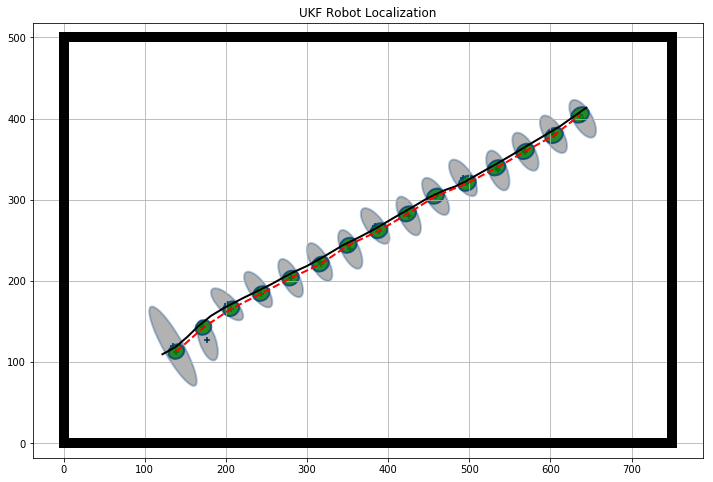

UKF standard deviation: [0.01166321 0.00650332] meters


In [330]:
rpm_motor = 130
omega_max = 2*np.pi*rpm_motor/60.0 # max motor speed
sigma_vel = omega_max*0.05         # std = 5% of max motor speed
sigma_range = 1200*0.03            # std of range sensors
sigma_bearing = np.radians(0.1)    # std of IMU absolute bearing

x = np.array([100, 100, 0.5])      # initial state
P = np.diag([2, 2, 0.05])          # initial covariance
cmds = [np.array([2.0, 2.1])] * 30 # constant inputs
xs, traj= run_simulation(cmds, x, P, sigma_vel, sigma_range, sigma_bearing, ellipse_step = 1, step=2)
print('UKF standard deviation:', np.std(xs[:,0:2]-traj[:,0:2],axis=0)/1000, 'meters')

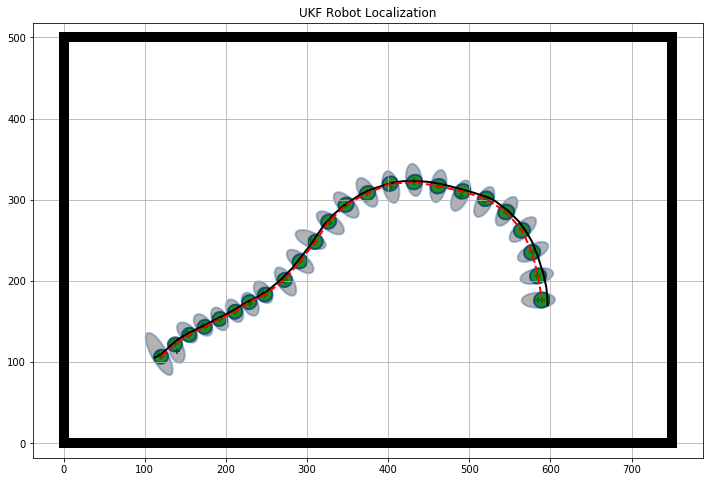

UKF standard deviation: [0.00988847 0.00813713] meters


In [307]:
# Generate a sequence of inputs (not constant input)
cmds = [np.array([1.0, 1.1])] * 15
cmds.extend([np.array([1.0, 2.0])])
cmds.extend([cmds[-1]]*5)
cmds.extend([np.array([2.0, 1.0])])
cmds.extend([cmds[-1]]*25)

x = np.array([100, 100, 0.5])
P = np.diag([2, 2, 0.05])
xs, traj= run_simulation(cmds, x, P, sigma_vel, sigma_range, sigma_bearing, ellipse_step = 2, step=2)
print('UKF standard deviation:', np.std(xs[:,0:2]-traj[:,0:2],axis=0)/1000, 'meters')

In [335]:
# Simulation with poor knowledage of the initial state
dt = 1.0
def run_simulation(cmds, x, P, sigma_vel, sigma_range, sigma_bearing,
                   ellipse_step=1, step=10):
    
    plt.figure(figsize=(12,8))
    ukf = ukf_build(x, P, sigma_range, sigma_bearing, dt=1.0)
    sim_pos = np.array([100, 100, 0.5])
    
    # Plot boundaries
    plt.plot([0, 0], [0, W], 'k', linewidth = '10')
    plt.plot([0, L], [0, 0], 'k', linewidth = '10')
    plt.plot([L, L], [0, W], 'k', linewidth = '10')
    plt.plot([0, L], [W, W], 'k', linewidth = '10')

    np.random.seed(1)
    traj = []
    xs = []
    for i, u in enumerate(cmds):
        sim_pos = noisy_move(sim_pos, dt/step, u, sigma_vel)
        traj.append(sim_pos)

        if i % step == 0:
            ukf.predict(u=u)
            
            if i % ellipse_step == 0:
                plot_covariance_ellipse((ukf.x[0], ukf.x[1]), ukf.P[0:2, 0:2], std=3,
                                       facecolor='k', alpha=0.3)
            
            #z = sensor.noisy_reading(np.array(ukf.x))
            z = noisy_reading(sim_pos, sigma_range, sigma_bearing)
            ukf.update(z)
            
            if i % ellipse_step == 0:
                plot_covariance_ellipse((ukf.x[0], ukf.x[1]), ukf.P[0:2, 0:2], std=3,
                                       facecolor='g', alpha=0.8)
        xs.append(ukf.x.copy())
    xs = np.array(xs)
    traj = np.array(traj)
    plt.plot(traj[:, 0], traj[:, 1], color='k', linewidth=2)
    plt.plot(xs[:, 0], xs[:, 1], 'r--', linewidth=2)
    plt.title("UKF Robot Localization")
    plt.grid()
    plt.axis('equal')
    plt.show()
    return xs, traj

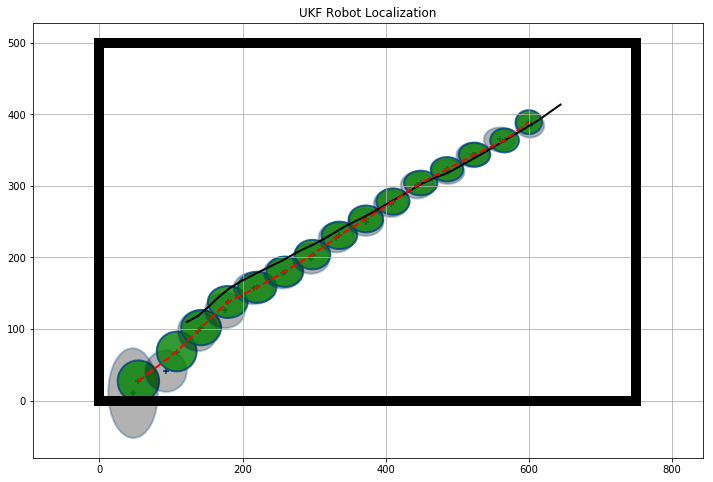

UKF standard deviation: [0.01347582 0.02072346] meters


In [334]:
x = np.array([10, 10, 0])             # initial state (far away from the real one)
P = np.diag([100, 100, 0.2])          # large covariance
cmds = [np.array([2.0, 2.1])] * 30
xs, traj= run_simulation(cmds, x, P, sigma_vel, sigma_range, sigma_bearing, ellipse_step = 1, step=2)
print('UKF standard deviation:', np.std(xs[:,0:2]-traj[:,0:2],axis=0)/1000, 'meters')